## Extract, Transform and Load

In [1]:
# import the required modules
from sqlalchemy import create_engine, Column, Integer, String, Date
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC 

In [2]:
# Create our database engine
engine = create_engine('sqlite:///heart_diagnosis.sqlite')

# Read data from CSV and load into a dataframe object
data = pd.read_csv('heart.csv')
 
# Write data into the table in PostgreSQL database
data.to_sql('heart_diagnosis',engine, if_exists = "replace", index = False)

In [3]:
# Query ALL Records in the database and create a dataframe
conn = engine.connect()
Heart_data = pd.read_sql("SELECT * FROM heart_diagnosis" , conn)
Heart_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
# Get number of rows and columns 
Heart_data.shape

(303, 14)

In [5]:
# Drop rows with missing data
cleaned_df = Heart_data.dropna()

In [6]:
# Get number of rows and columns after dropping rows with missing data
cleaned_df.shape

(303, 14)

In [7]:
# Check all the data types for all the columns
cleaned_df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [8]:
# Determine the number of unique values in each column.
cleaned_df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

## Logistic Regression model

In [9]:
## Split the data into Features and Target 
target = cleaned_df['target']
features = cleaned_df.drop(columns=['target'])
target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [10]:
# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state =1)

In [11]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [12]:
# Declare a logistic regression model.
LR_model_train_test = LogisticRegression(solver='lbfgs',max_iter=1000,random_state=1)

# Fit and save the logistic regression model using the training data
LR_model_train_test.fit(X_train_scaled, y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': LR_model_train_test.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

#Generate testing predictions
testing_predictions = LR_model_train_test.predict(X_test_scaled)

In [13]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, testing_predictions)

array([[24, 11],
       [ 8, 33]], dtype=int64)

In [14]:
# Print the balanced_accuracy score of the model

balanced_accuracy_score(y_test, testing_predictions)

0.7452961672473868

In [15]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions,target_names = ["less chance" , "more chance"])

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 less chance       0.75      0.69      0.72        35
 more chance       0.75      0.80      0.78        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



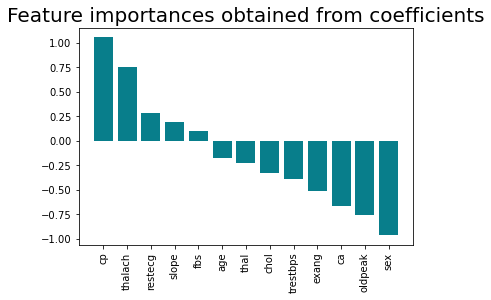

In [16]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
#Optimization Feature Importance

features_optimized = features.drop(columns=['restecg'])
features_optimized = features_optimized.drop(columns=['fbs'])
features_optimized = features_optimized.drop(columns=['cp'])

features_optimized

,age,sex,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal
0,63,1,145,233,150,0,2.3,0,0,1
1,37,1,130,250,187,0,3.5,0,0,2
2,41,0,130,204,172,0,1.4,2,0,2
3,56,1,120,236,178,0,0.8,2,0,2
4,57,0,120,354,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,123,1,0.2,1,0,3
299,45,1,110,264,132,0,1.2,1,0,3
300,68,1,144,193,141,0,3.4,1,2,3
301,57,1,130,131,115,1,1.2,1,1,3


In [18]:
# Split into testing and training sets using train_test_split
X_train_optim, X_test_optim, y_train_optim, y_test_optim = train_test_split(features_optimized, target, random_state =1)

# Create a StandardScaler instances
scaler_optim = StandardScaler()

# Fit the StandardScaler
X_scaler_optim = scaler_optim.fit(X_train_optim)

# Scale the data
X_train_scaled_optim = X_scaler_optim.transform(X_train_optim)
X_test_scaled_optim = X_scaler_optim.transform(X_test_optim)

# Declare a logistic regression model.
LR_model_train_test_optim = LogisticRegression(solver='lbfgs',max_iter=1000,random_state=1)

# Fit and save the logistic regression model using the training data
LR_model_train_test_optim.fit(X_train_scaled_optim, y_train_optim)

#Generate testing predictions
testing_predictions_optim = LR_model_train_test_optim.predict(X_test_scaled_optim)


In [19]:
# Generate a confusion matrix for the model
confusion_matrix(y_test_optim, testing_predictions_optim)

array([[27,  8],
       [ 5, 36]], dtype=int64)

In [20]:
# Print the balanced_accuracy score of the model

balanced_accuracy_score(y_test_optim, testing_predictions_optim)

0.8247386759581882

In [21]:
# Create and save the testing classification report
testing_report_optim = classification_report(y_test_optim, testing_predictions_optim,target_names = ["less chance" , "more chance"])

# Print the testing classification report
print(testing_report_optim)

              precision    recall  f1-score   support

 less chance       0.84      0.77      0.81        35
 more chance       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



## Support Vector Machine model

In [22]:
## Split the data into Features and Target 
target = cleaned_df['target']
features = cleaned_df.drop(columns=['target'])
target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [23]:
# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state =1)

In [24]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
# Declare a SVCmodel.
SVC_model_train_test = SVC(kernel='linear')

# Fit and save the SVC model using the training data
SVC_model_trained = SVC_model_train_test.fit(X_train, y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': SVC_model_trained.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

#Generate testing predictions
testing_predictions = SVC_model_trained.predict(X_test_scaled)

C:\Users\17323\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


In [28]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, testing_predictions)

array([[15, 20],
       [ 1, 40]], dtype=int64)

In [29]:
# Print the balanced_accuracy score of the model

balanced_accuracy_score(y_test, testing_predictions)

0.7020905923344948

In [30]:
# Create and save the testing classification report
testing_report = classification_report(y_test, testing_predictions,target_names = ["less chance" , "more chance"])

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

 less chance       0.94      0.43      0.59        35
 more chance       0.67      0.98      0.79        41

    accuracy                           0.72        76
   macro avg       0.80      0.70      0.69        76
weighted avg       0.79      0.72      0.70        76



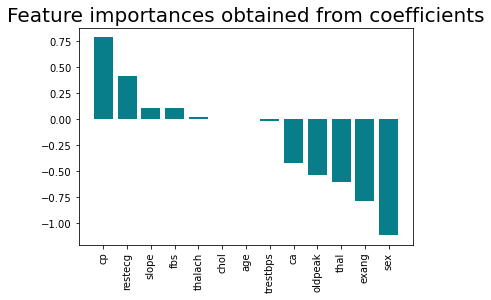

In [31]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [50]:
#Optimization Feature Importance

features_optimized = features.drop(columns=['restecg'])
features_optimized = features_optimized.drop(columns=['fbs'])
features_optimized = features_optimized.drop(columns=['cp'])

features_optimized

,age,sex,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal
0,63,1,145,233,150,0,2.3,0,0,1
1,37,1,130,250,187,0,3.5,0,0,2
2,41,0,130,204,172,0,1.4,2,0,2
3,56,1,120,236,178,0,0.8,2,0,2
4,57,0,120,354,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,123,1,0.2,1,0,3
299,45,1,110,264,132,0,1.2,1,0,3
300,68,1,144,193,141,0,3.4,1,2,3
301,57,1,130,131,115,1,1.2,1,1,3


In [51]:
# Split into testing and training sets using train_test_split
X_train_optim, X_test_optim, y_train_optim, y_test_optim = train_test_split(features_optimized, target, random_state =1)

# Create a StandardScaler instances
scaler_optim = StandardScaler()

# Fit the StandardScaler
X_scaler_optim = scaler_optim.fit(X_train_optim)

# Scale the data
X_train_scaled_optim = X_scaler_optim.transform(X_train_optim)
X_test_scaled_optim = X_scaler_optim.transform(X_test_optim)

# Declare a SVC model.
SVC_model_train_test_optim = SVC(kernel='linear')

# Fit and save the SVC model using the training data
SVC_model_trained_optim = SVC_model_train_test_optim.fit(X_train_optim, y_train_optim)

#Generate testing predictions
testing_predictions_optim = SVC_model_trained_optim.predict(X_test_scaled_optim)


C:\Users\17323\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


In [52]:
# Generate a confusion matrix for the model
confusion_matrix(y_test_optim, testing_predictions_optim)

array([[28,  7],
       [ 6, 35]], dtype=int64)

In [53]:
# Print the balanced_accuracy score of the model

balanced_accuracy_score(y_test_optim, testing_predictions_optim)

0.826829268292683

In [54]:
# Create and save the testing classification report
testing_report_optim = classification_report(y_test_optim, testing_predictions_optim,target_names = ["less chance" , "more chance"])

# Print the testing classification report
print(testing_report_optim)

              precision    recall  f1-score   support

 less chance       0.82      0.80      0.81        35
 more chance       0.83      0.85      0.84        41

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76

